In [1]:


import sys
import shap 
import pickle
import sklearn 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace 



In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results







In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="dd_fix_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [6]:
configs.specifier = specifier
configs.data_name = data_name



In [7]:

configs.specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

# Fix_demo-noIQ-Fcls-mm:

- Chosen model: **MLP**



https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

## Load Data

In [8]:

dd = DyslexiaData(path="../../datasets/", n_repeats=5)




In [9]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 


In [10]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,1,177.3,531.8,219.0,1,4,10,23,102.0
1,1,10,4,2,200.5,545.2,247.0,1,4,10,23,102.0
2,1,10,4,3,282.7,542.4,261.0,1,4,10,23,102.0
3,1,10,4,4,358.1,545.5,268.0,1,4,10,23,102.0
4,1,10,4,4,392.8,536.3,129.0,1,4,10,23,102.0


In [11]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [12]:

x_org.head()



,Sex_2,FIX_Y,FIX_X,Sex_1,Grade_3,FIX_DURATION,IQ,Grade_1,Grade_5,Grade_4,Grade_6,Grade_2,Age
0,0,531.8,177.3,1,0,219.0,23,0,0,1,0,0,10
1,0,545.2,200.5,1,0,247.0,23,0,0,1,0,0,10
2,0,542.4,282.7,1,0,261.0,23,0,0,1,0,0,10
3,0,545.5,358.1,1,0,268.0,23,0,0,1,0,0,10
4,0,536.3,392.8,1,0,129.0,23,0,0,1,0,0,10


In [13]:

features_fixed_order = [
    "FIX_X", "FIX_Y", "FIX_DURATION", "Age", 
    "Sex_1", "Sex_2", 
    "Grade_1", "Grade_2", "Grade_3", "Grade_4", "Grade_5", "Grade_6"
]


x_org = x_org.loc[:, features_fixed_order]

x_org.head()



,FIX_X,FIX_Y,FIX_DURATION,Age,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
0,177.3,531.8,219.0,10,1,0,0,0,0,1,0,0
1,200.5,545.2,247.0,10,1,0,0,0,0,1,0,0
2,282.7,542.4,261.0,10,1,0,0,0,0,1,0,0
3,358.1,545.5,268.0,10,1,0,0,0,0,1,0,0
4,392.8,536.3,129.0,10,1,0,0,0,0,1,0,0


In [14]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [15]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [16]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (225350, 12)


In [17]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=to_shuffle,
        n_splits=10
    )



In [18]:

data



defaultdict(collections.defaultdict,
            {'1': defaultdict(list,
                         {'x_train': array([[0.06 , 0.537, 0.025, ..., 1.   , 0.   , 0.   ],
                                 [0.121, 0.53 , 0.027, ..., 1.   , 0.   , 0.   ],
                                 [0.177, 0.538, 0.027, ..., 1.   , 0.   , 0.   ],
                                 ...,
                                 [0.609, 0.579, 0.022, ..., 0.   , 0.   , 0.   ],
                                 [0.528, 0.546, 0.015, ..., 0.   , 0.   , 0.   ],
                                 [0.644, 0.538, 0.019, ..., 0.   , 0.   , 0.   ]]),
                          'x_test': array([[0.043, 0.503, 0.022, ..., 1.   , 0.   , 0.   ],
                                 [0.346, 0.511, 0.022, ..., 1.   , 0.   , 0.   ],
                                 [0.547, 0.52 , 0.004, ..., 1.   , 0.   , 0.   ],
                                 ...,
                                 [0.192, 0.52 , 0.017, ..., 0.   , 0.   , 0.   ],
        

## Load the tuned parameters

In [19]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 158),
             ('max_iter', 49150),
             ('solver', 'lbfgs')])

In [20]:

# specifier




In [ ]:
# save_a_dict(a_dict=tuned_params,
#             name='dd_fix_demo-mlp_reg--shuffled:True--exclude at risk:0',
#             save_path=configs.params_path,
#            )

In [21]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl


MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [22]:


x_train = data["6"]["x_train"]
x_test = data["6"]["x_test"]
y_train = data["6"]["y_train"]
y_test = data["6"]["y_test"]



In [23]:

class_names = ['Norm', 'At-risk', 'Dyslexic']




## Previous result as per paper

Let us load and print the save results from the paper

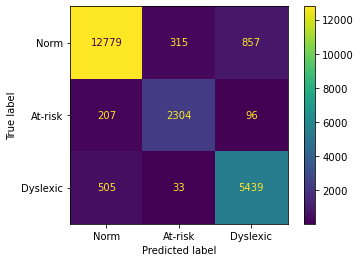

Kappa: 0.8347400437872468 AUC ROC: 0.9825072610728137


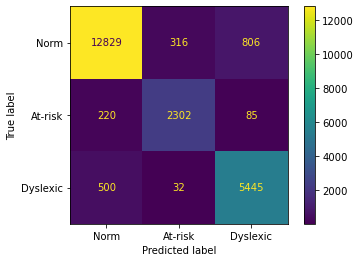

Kappa: 0.8388978522946917 AUC ROC: 0.9829182453627607


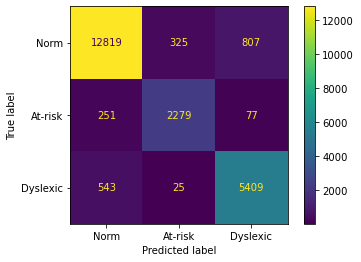

Kappa: 0.832869081391151 AUC ROC: 0.9823166765651608


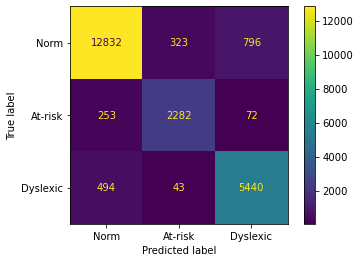

Kappa: 0.8369422822490217 AUC ROC: 0.9828148640073884


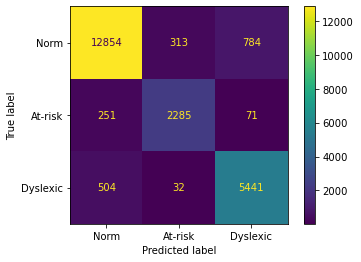

Kappa: 0.8389059114142479 AUC ROC: 0.9829848306845811


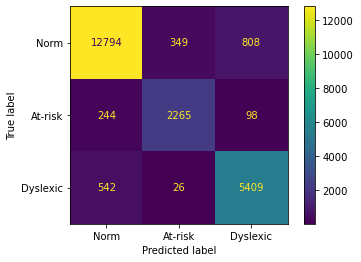

Kappa: 0.829841840423335 AUC ROC: 0.9823257928381303


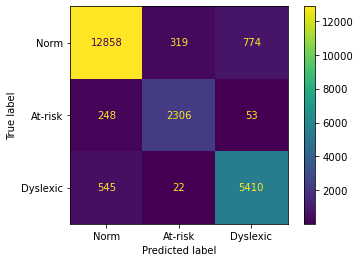

Kappa: 0.8382473045222396 AUC ROC: 0.9827749230027788


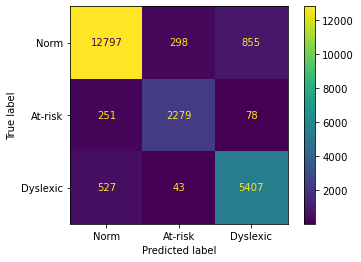

Kappa: 0.8310664313696852 AUC ROC: 0.9821932698756151


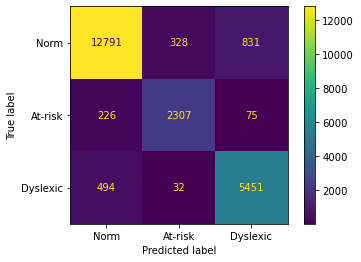

Kappa: 0.8368983636632326 AUC ROC: 0.9830666923198533


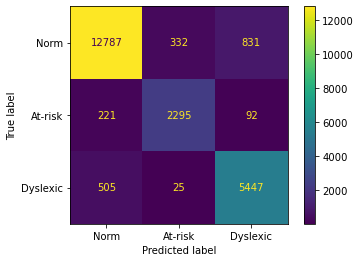

Kappa: 0.8352159256796329 AUC ROC: 0.9824885993933525


In [24]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )




for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    y_prob_ = results[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )





In [25]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)



  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.730 0.004 0.631 0.005 0.913 0.002 0.911 0.002 0.912 0.002 0.983 0.000 1.978 0.011 0.103 0.001 0.911 0.002 0.929 0.002



### Retraining with fixed and reordered features


In [ ]:


mdl.fit(x_train, y_train)




 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2531     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22721D+00    |proj g|=  3.71936D-01

At iterate    1    f=  1.15960D+00    |proj g|=  2.85190D-01

At iterate    2    f=  8.75811D-01    |proj g|=  7.44863D-02

At iterate    3    f=  8.55466D-01    |proj g|=  3.54953D-02

At iterate    4    f=  8.48168D-01    |proj g|=  1.68598D-02

At iterate    5    f=  8.28430D-01    |proj g|=  2.06980D-02

At iterate    6    f=  8.16298D-01    |proj g|=  1.73567D-02

At iterate    7    f=  8.08626D-01    |proj g|=  1.20932D-02

At iterate    8    f=  8.04280D-01    |proj g|=  3.37909D-03

At iterate    9    f=  8.01309D-01    |proj g|=  2.39246D-03

At iterate   10    f=  7.98020D-01    |proj g|=  4.31231D-03

At iterate   11    f=  7.93994D-01    |proj g|=  3.12970D-03

At iterate   12    f=  7.92184D-01    |proj g|=  4.67104D-03

At iterate   13    f=  7.9


At iterate  130    f=  6.98293D-01    |proj g|=  1.13788D-02

At iterate  131    f=  6.97667D-01    |proj g|=  1.18627D-02

At iterate  132    f=  6.96353D-01    |proj g|=  1.33772D-02

At iterate  133    f=  6.94750D-01    |proj g|=  9.72880D-03

At iterate  134    f=  6.92651D-01    |proj g|=  8.96714D-03

At iterate  135    f=  6.90271D-01    |proj g|=  5.93359D-03

At iterate  136    f=  6.89384D-01    |proj g|=  1.07913D-02

At iterate  137    f=  6.88974D-01    |proj g|=  9.34076D-03

At iterate  138    f=  6.88670D-01    |proj g|=  7.31154D-03

At iterate  139    f=  6.88467D-01    |proj g|=  6.04320D-03

At iterate  140    f=  6.87829D-01    |proj g|=  6.02030D-03

At iterate  141    f=  6.87031D-01    |proj g|=  6.39975D-03

At iterate  142    f=  6.86634D-01    |proj g|=  4.90034D-03

At iterate  143    f=  6.86080D-01    |proj g|=  3.37845D-03

At iterate  144    f=  6.85872D-01    |proj g|=  5.68923D-03

At iterate  145    f=  6.85685D-01    |proj g|=  5.59153D-03

At iter


At iterate  263    f=  6.51843D-01    |proj g|=  4.70797D-03

At iterate  264    f=  6.51537D-01    |proj g|=  4.37162D-03

At iterate  265    f=  6.51101D-01    |proj g|=  6.44584D-03

At iterate  266    f=  6.50873D-01    |proj g|=  5.99211D-03

At iterate  267    f=  6.50659D-01    |proj g|=  5.11525D-03

At iterate  268    f=  6.50433D-01    |proj g|=  1.42341D-02

At iterate  269    f=  6.50087D-01    |proj g|=  7.46868D-03

At iterate  270    f=  6.49780D-01    |proj g|=  7.58626D-03

At iterate  271    f=  6.49144D-01    |proj g|=  1.08799D-02

At iterate  272    f=  6.48782D-01    |proj g|=  6.95692D-03

At iterate  273    f=  6.48266D-01    |proj g|=  6.25285D-03

At iterate  274    f=  6.48000D-01    |proj g|=  5.47732D-03

At iterate  275    f=  6.47762D-01    |proj g|=  5.04424D-03

At iterate  276    f=  6.47406D-01    |proj g|=  4.46543D-03

At iterate  277    f=  6.47098D-01    |proj g|=  1.03227D-02

At iterate  278    f=  6.46672D-01    |proj g|=  6.21551D-03

At iter


At iterate  396    f=  6.11251D-01    |proj g|=  6.13065D-03

At iterate  397    f=  6.11141D-01    |proj g|=  9.86535D-03

At iterate  398    f=  6.10984D-01    |proj g|=  6.82561D-03

At iterate  399    f=  6.10740D-01    |proj g|=  4.35775D-03

At iterate  400    f=  6.10521D-01    |proj g|=  4.61266D-03

At iterate  401    f=  6.10347D-01    |proj g|=  2.18082D-02

At iterate  402    f=  6.10048D-01    |proj g|=  5.92779D-03

At iterate  403    f=  6.09931D-01    |proj g|=  3.14267D-03

At iterate  404    f=  6.09802D-01    |proj g|=  1.07293D-02

At iterate  405    f=  6.09747D-01    |proj g|=  8.37092D-03

At iterate  406    f=  6.09673D-01    |proj g|=  6.44584D-03

At iterate  407    f=  6.09582D-01    |proj g|=  3.23088D-03

At iterate  408    f=  6.09503D-01    |proj g|=  3.92974D-03

At iterate  409    f=  6.09400D-01    |proj g|=  6.00441D-03

At iterate  410    f=  6.09344D-01    |proj g|=  9.38673D-03

At iterate  411    f=  6.09266D-01    |proj g|=  5.26151D-03

At iter


At iterate  529    f=  5.98089D-01    |proj g|=  3.42910D-03

At iterate  530    f=  5.98044D-01    |proj g|=  2.93787D-03

At iterate  531    f=  5.98010D-01    |proj g|=  7.56961D-03

At iterate  532    f=  5.97963D-01    |proj g|=  3.47910D-03

At iterate  533    f=  5.97913D-01    |proj g|=  3.49377D-03

At iterate  534    f=  5.97866D-01    |proj g|=  4.62296D-03

At iterate  535    f=  5.97792D-01    |proj g|=  5.86140D-03

At iterate  536    f=  5.97760D-01    |proj g|=  7.01641D-03

At iterate  537    f=  5.97725D-01    |proj g|=  2.38414D-03

At iterate  538    f=  5.97705D-01    |proj g|=  2.85006D-03

At iterate  539    f=  5.97675D-01    |proj g|=  3.23739D-03

At iterate  540    f=  5.97652D-01    |proj g|=  1.25699D-02

At iterate  541    f=  5.97615D-01    |proj g|=  7.99037D-03

At iterate  542    f=  5.97548D-01    |proj g|=  3.14791D-03

At iterate  543    f=  5.97517D-01    |proj g|=  3.28492D-03

At iterate  544    f=  5.97466D-01    |proj g|=  8.98517D-03

At iter


At iterate  662    f=  5.91630D-01    |proj g|=  3.62253D-03

At iterate  663    f=  5.91608D-01    |proj g|=  4.11098D-03

At iterate  664    f=  5.91567D-01    |proj g|=  3.40971D-03

At iterate  665    f=  5.91520D-01    |proj g|=  1.42315D-02

At iterate  666    f=  5.91458D-01    |proj g|=  7.60104D-03

At iterate  667    f=  5.91394D-01    |proj g|=  4.87911D-03

At iterate  668    f=  5.91361D-01    |proj g|=  5.70420D-03

At iterate  669    f=  5.91239D-01    |proj g|=  1.31613D-02

At iterate  670    f=  5.91194D-01    |proj g|=  9.00982D-03

At iterate  671    f=  5.91142D-01    |proj g|=  4.31635D-03

At iterate  672    f=  5.91108D-01    |proj g|=  2.11937D-03

At iterate  673    f=  5.91072D-01    |proj g|=  2.55546D-03

At iterate  674    f=  5.91026D-01    |proj g|=  4.58630D-03

At iterate  675    f=  5.90992D-01    |proj g|=  5.54432D-03

At iterate  676    f=  5.90938D-01    |proj g|=  3.11357D-03

At iterate  677    f=  5.90884D-01    |proj g|=  3.28786D-03

At iter


At iterate  795    f=  5.86483D-01    |proj g|=  3.64157D-03

At iterate  796    f=  5.86469D-01    |proj g|=  5.92034D-03

At iterate  797    f=  5.86450D-01    |proj g|=  3.56841D-03

At iterate  798    f=  5.86428D-01    |proj g|=  2.81110D-03

At iterate  799    f=  5.86405D-01    |proj g|=  4.11147D-03

At iterate  800    f=  5.86354D-01    |proj g|=  2.78465D-03

At iterate  801    f=  5.86339D-01    |proj g|=  1.17443D-02

At iterate  802    f=  5.86296D-01    |proj g|=  2.88872D-03

At iterate  803    f=  5.86273D-01    |proj g|=  1.99663D-03

At iterate  804    f=  5.86261D-01    |proj g|=  1.39050D-02

At iterate  805    f=  5.86241D-01    |proj g|=  5.52809D-03

At iterate  806    f=  5.86225D-01    |proj g|=  2.89187D-03

At iterate  807    f=  5.86211D-01    |proj g|=  4.87529D-03

At iterate  808    f=  5.86192D-01    |proj g|=  5.54431D-03

At iterate  809    f=  5.86140D-01    |proj g|=  9.62542D-03

At iterate  810    f=  5.86088D-01    |proj g|=  8.19207D-03

At iter


At iterate  928    f=  5.82633D-01    |proj g|=  3.92833D-03

At iterate  929    f=  5.82600D-01    |proj g|=  6.40376D-03

At iterate  930    f=  5.82577D-01    |proj g|=  4.72538D-03

At iterate  931    f=  5.82540D-01    |proj g|=  4.70720D-03

At iterate  932    f=  5.82462D-01    |proj g|=  7.98211D-03

At iterate  933    f=  5.82412D-01    |proj g|=  3.90818D-03

At iterate  934    f=  5.82376D-01    |proj g|=  5.00959D-03

At iterate  935    f=  5.82326D-01    |proj g|=  3.81696D-03

At iterate  936    f=  5.82254D-01    |proj g|=  3.59294D-03

At iterate  937    f=  5.82212D-01    |proj g|=  8.31208D-03

At iterate  938    f=  5.82174D-01    |proj g|=  7.57425D-03

At iterate  939    f=  5.82143D-01    |proj g|=  3.79688D-03

At iterate  940    f=  5.82116D-01    |proj g|=  3.03080D-03

At iterate  941    f=  5.82091D-01    |proj g|=  4.15005D-03

At iterate  942    f=  5.82044D-01    |proj g|=  4.16349D-03

At iterate  943    f=  5.82010D-01    |proj g|=  8.60554D-03

At iter


At iterate 1061    f=  5.78445D-01    |proj g|=  3.31342D-03

At iterate 1062    f=  5.78437D-01    |proj g|=  1.47586D-02

At iterate 1063    f=  5.78406D-01    |proj g|=  5.25435D-03

At iterate 1064    f=  5.78387D-01    |proj g|=  2.29207D-03

At iterate 1065    f=  5.78372D-01    |proj g|=  5.50379D-03

At iterate 1066    f=  5.78351D-01    |proj g|=  5.71825D-03

At iterate 1067    f=  5.78333D-01    |proj g|=  9.88293D-03

At iterate 1068    f=  5.78304D-01    |proj g|=  3.67188D-03

At iterate 1069    f=  5.78293D-01    |proj g|=  1.60020D-03

At iterate 1070    f=  5.78283D-01    |proj g|=  3.48859D-03

At iterate 1071    f=  5.78266D-01    |proj g|=  4.76614D-03

At iterate 1072    f=  5.78233D-01    |proj g|=  6.75781D-03

At iterate 1073    f=  5.78214D-01    |proj g|=  7.59587D-03

At iterate 1074    f=  5.78183D-01    |proj g|=  4.63100D-03

At iterate 1075    f=  5.78163D-01    |proj g|=  2.19678D-03

At iterate 1076    f=  5.78152D-01    |proj g|=  3.01258D-03

At iter


At iterate 1194    f=  5.75460D-01    |proj g|=  3.07114D-03

At iterate 1195    f=  5.75447D-01    |proj g|=  3.78593D-03

At iterate 1196    f=  5.75435D-01    |proj g|=  9.46364D-03

At iterate 1197    f=  5.75405D-01    |proj g|=  3.09099D-03

At iterate 1198    f=  5.75388D-01    |proj g|=  1.85845D-03

At iterate 1199    f=  5.75370D-01    |proj g|=  5.25237D-03

At iterate 1200    f=  5.75351D-01    |proj g|=  4.43521D-03

At iterate 1201    f=  5.75336D-01    |proj g|=  9.87870D-03

At iterate 1202    f=  5.75308D-01    |proj g|=  3.46206D-03

At iterate 1203    f=  5.75290D-01    |proj g|=  2.23889D-03

At iterate 1204    f=  5.75270D-01    |proj g|=  5.31846D-03

At iterate 1205    f=  5.75248D-01    |proj g|=  3.82550D-03

At iterate 1206    f=  5.75228D-01    |proj g|=  3.13739D-03

At iterate 1207    f=  5.75200D-01    |proj g|=  3.18530D-03

At iterate 1208    f=  5.75180D-01    |proj g|=  2.09600D-03

At iterate 1209    f=  5.75168D-01    |proj g|=  6.09710D-03

At iter


At iterate 1327    f=  5.72766D-01    |proj g|=  2.44279D-03

At iterate 1328    f=  5.72748D-01    |proj g|=  1.72523D-03

At iterate 1329    f=  5.72720D-01    |proj g|=  2.66046D-03

At iterate 1330    f=  5.72702D-01    |proj g|=  2.65445D-03

At iterate 1331    f=  5.72692D-01    |proj g|=  3.20890D-03

At iterate 1332    f=  5.72684D-01    |proj g|=  1.80957D-03

At iterate 1333    f=  5.72674D-01    |proj g|=  1.93543D-03

At iterate 1334    f=  5.72665D-01    |proj g|=  2.16747D-03

At iterate 1335    f=  5.72645D-01    |proj g|=  6.14213D-03

At iterate 1336    f=  5.72624D-01    |proj g|=  2.25651D-03

At iterate 1337    f=  5.72608D-01    |proj g|=  2.10353D-03

At iterate 1338    f=  5.72584D-01    |proj g|=  2.86518D-03

At iterate 1339    f=  5.72567D-01    |proj g|=  2.88526D-03

At iterate 1340    f=  5.72557D-01    |proj g|=  6.93680D-03

At iterate 1341    f=  5.72536D-01    |proj g|=  1.68978D-03

At iterate 1342    f=  5.72529D-01    |proj g|=  2.18993D-03

At iter


At iterate 1460    f=  5.71196D-01    |proj g|=  1.84188D-03

At iterate 1461    f=  5.71189D-01    |proj g|=  2.95381D-03

At iterate 1462    f=  5.71178D-01    |proj g|=  2.26244D-03

At iterate 1463    f=  5.71171D-01    |proj g|=  1.51628D-03

At iterate 1464    f=  5.71163D-01    |proj g|=  1.51143D-03

At iterate 1465    f=  5.71152D-01    |proj g|=  1.49383D-03

At iterate 1466    f=  5.71132D-01    |proj g|=  2.75040D-03

At iterate 1467    f=  5.71122D-01    |proj g|=  1.64340D-03

At iterate 1468    f=  5.71114D-01    |proj g|=  1.41527D-03

At iterate 1469    f=  5.71107D-01    |proj g|=  1.13489D-03

At iterate 1470    f=  5.71099D-01    |proj g|=  2.03034D-03

At iterate 1471    f=  5.71089D-01    |proj g|=  5.03670D-03

At iterate 1472    f=  5.71071D-01    |proj g|=  1.65086D-03

At iterate 1473    f=  5.71065D-01    |proj g|=  1.28556D-03

At iterate 1474    f=  5.71063D-01    |proj g|=  3.59815D-03

At iterate 1475    f=  5.71058D-01    |proj g|=  1.55842D-03

At iter


At iterate 1593    f=  5.69854D-01    |proj g|=  6.23693D-03

At iterate 1594    f=  5.69843D-01    |proj g|=  2.11762D-03

At iterate 1595    f=  5.69834D-01    |proj g|=  1.85870D-03

At iterate 1596    f=  5.69823D-01    |proj g|=  1.95705D-03

At iterate 1597    f=  5.69809D-01    |proj g|=  2.37032D-03

At iterate 1598    f=  5.69806D-01    |proj g|=  8.20468D-03

At iterate 1599    f=  5.69789D-01    |proj g|=  1.37514D-03

At iterate 1600    f=  5.69785D-01    |proj g|=  1.45944D-03

At iterate 1601    f=  5.69774D-01    |proj g|=  1.09635D-03

At iterate 1602    f=  5.69763D-01    |proj g|=  3.99676D-03

At iterate 1603    f=  5.69753D-01    |proj g|=  1.66454D-03

At iterate 1604    f=  5.69744D-01    |proj g|=  1.81152D-03

At iterate 1605    f=  5.69732D-01    |proj g|=  2.70808D-03

At iterate 1606    f=  5.69722D-01    |proj g|=  4.34091D-03

At iterate 1607    f=  5.69710D-01    |proj g|=  1.63089D-03

At iterate 1608    f=  5.69706D-01    |proj g|=  9.84724D-04

At iter


At iterate 1726    f=  5.68052D-01    |proj g|=  1.40618D-03

At iterate 1727    f=  5.68040D-01    |proj g|=  3.27139D-03

At iterate 1728    f=  5.68032D-01    |proj g|=  2.91764D-03

At iterate 1729    f=  5.68025D-01    |proj g|=  1.53373D-03

At iterate 1730    f=  5.68014D-01    |proj g|=  1.53916D-03

At iterate 1731    f=  5.68004D-01    |proj g|=  1.45955D-03

At iterate 1732    f=  5.67998D-01    |proj g|=  6.14284D-03

At iterate 1733    f=  5.67979D-01    |proj g|=  3.63402D-03

At iterate 1734    f=  5.67962D-01    |proj g|=  1.73884D-03

At iterate 1735    f=  5.67949D-01    |proj g|=  1.49045D-03

At iterate 1736    f=  5.67938D-01    |proj g|=  1.96738D-03

At iterate 1737    f=  5.67932D-01    |proj g|=  5.95857D-03

At iterate 1738    f=  5.67914D-01    |proj g|=  1.72878D-03

At iterate 1739    f=  5.67905D-01    |proj g|=  1.89461D-03

At iterate 1740    f=  5.67895D-01    |proj g|=  2.28374D-03

At iterate 1741    f=  5.67884D-01    |proj g|=  4.65765D-03

At iter


At iterate 1859    f=  5.66479D-01    |proj g|=  1.19957D-03

At iterate 1860    f=  5.66468D-01    |proj g|=  1.59966D-03

At iterate 1861    f=  5.66457D-01    |proj g|=  4.04155D-03

At iterate 1862    f=  5.66446D-01    |proj g|=  2.24974D-03

At iterate 1863    f=  5.66440D-01    |proj g|=  1.26237D-03

At iterate 1864    f=  5.66435D-01    |proj g|=  1.63915D-03

At iterate 1865    f=  5.66431D-01    |proj g|=  1.98495D-03

At iterate 1866    f=  5.66424D-01    |proj g|=  1.87868D-03

At iterate 1867    f=  5.66405D-01    |proj g|=  2.36355D-03

At iterate 1868    f=  5.66384D-01    |proj g|=  2.68505D-03

At iterate 1869    f=  5.66367D-01    |proj g|=  3.85710D-03

At iterate 1870    f=  5.66353D-01    |proj g|=  1.30029D-03

At iterate 1871    f=  5.66339D-01    |proj g|=  1.35267D-03

At iterate 1872    f=  5.66323D-01    |proj g|=  3.50998D-03

At iterate 1873    f=  5.66304D-01    |proj g|=  4.14586D-03

At iterate 1874    f=  5.66290D-01    |proj g|=  1.97022D-03

At iter


At iterate 1992    f=  5.65124D-01    |proj g|=  1.63593D-03

At iterate 1993    f=  5.65119D-01    |proj g|=  1.13830D-03

At iterate 1994    f=  5.65110D-01    |proj g|=  1.60172D-03

At iterate 1995    f=  5.65100D-01    |proj g|=  1.61459D-03

At iterate 1996    f=  5.65082D-01    |proj g|=  1.81799D-03

At iterate 1997    f=  5.65078D-01    |proj g|=  2.78607D-03

At iterate 1998    f=  5.65069D-01    |proj g|=  1.37405D-03

At iterate 1999    f=  5.65065D-01    |proj g|=  1.18821D-03

At iterate 2000    f=  5.65060D-01    |proj g|=  2.93952D-03

At iterate 2001    f=  5.65054D-01    |proj g|=  1.72802D-03

At iterate 2002    f=  5.65042D-01    |proj g|=  1.53349D-03

At iterate 2003    f=  5.65037D-01    |proj g|=  1.52707D-03

At iterate 2004    f=  5.65030D-01    |proj g|=  5.45104D-03

At iterate 2005    f=  5.65020D-01    |proj g|=  1.48067D-03

At iterate 2006    f=  5.65016D-01    |proj g|=  8.71532D-04

At iterate 2007    f=  5.65011D-01    |proj g|=  1.00024D-03

At iter


At iterate 2125    f=  5.64101D-01    |proj g|=  6.33426D-03

At iterate 2126    f=  5.64091D-01    |proj g|=  1.74397D-03

At iterate 2127    f=  5.64086D-01    |proj g|=  1.21843D-03

At iterate 2128    f=  5.64081D-01    |proj g|=  1.20944D-03

At iterate 2129    f=  5.64074D-01    |proj g|=  1.16341D-03

At iterate 2130    f=  5.64066D-01    |proj g|=  4.03838D-03

At iterate 2131    f=  5.64053D-01    |proj g|=  1.32604D-03

At iterate 2132    f=  5.64048D-01    |proj g|=  9.65126D-04

At iterate 2133    f=  5.64043D-01    |proj g|=  2.08131D-03

At iterate 2134    f=  5.64039D-01    |proj g|=  9.52488D-04

At iterate 2135    f=  5.64034D-01    |proj g|=  8.22631D-04

At iterate 2136    f=  5.64020D-01    |proj g|=  1.12163D-03

At iterate 2137    f=  5.64007D-01    |proj g|=  1.51607D-03

At iterate 2138    f=  5.64002D-01    |proj g|=  3.71817D-03

At iterate 2139    f=  5.63992D-01    |proj g|=  1.31167D-03

At iterate 2140    f=  5.63986D-01    |proj g|=  1.14661D-03

At iter


At iterate 2258    f=  5.62962D-01    |proj g|=  2.61766D-03

At iterate 2259    f=  5.62952D-01    |proj g|=  3.82247D-03

At iterate 2260    f=  5.62940D-01    |proj g|=  3.11616D-03

At iterate 2261    f=  5.62928D-01    |proj g|=  1.68292D-03

At iterate 2262    f=  5.62920D-01    |proj g|=  1.76944D-03

At iterate 2263    f=  5.62912D-01    |proj g|=  1.40108D-03

At iterate 2264    f=  5.62904D-01    |proj g|=  3.32450D-03

At iterate 2265    f=  5.62892D-01    |proj g|=  1.72529D-03

At iterate 2266    f=  5.62885D-01    |proj g|=  1.12843D-03

At iterate 2267    f=  5.62878D-01    |proj g|=  1.68750D-03

At iterate 2268    f=  5.62873D-01    |proj g|=  4.34056D-03

At iterate 2269    f=  5.62866D-01    |proj g|=  2.26617D-03

At iterate 2270    f=  5.62859D-01    |proj g|=  2.26405D-03

At iterate 2271    f=  5.62852D-01    |proj g|=  1.83739D-03

At iterate 2272    f=  5.62842D-01    |proj g|=  1.69661D-03

At iterate 2273    f=  5.62835D-01    |proj g|=  3.10784D-03

At iter


At iterate 2391    f=  5.61870D-01    |proj g|=  1.97519D-03

At iterate 2392    f=  5.61862D-01    |proj g|=  1.69254D-03

At iterate 2393    f=  5.61851D-01    |proj g|=  2.08041D-03

At iterate 2394    f=  5.61845D-01    |proj g|=  3.52419D-03

At iterate 2395    f=  5.61834D-01    |proj g|=  1.79971D-03

At iterate 2396    f=  5.61829D-01    |proj g|=  1.45983D-03

At iterate 2397    f=  5.61824D-01    |proj g|=  1.19158D-03

At iterate 2398    f=  5.61820D-01    |proj g|=  6.14916D-03

At iterate 2399    f=  5.61812D-01    |proj g|=  1.77247D-03

At iterate 2400    f=  5.61807D-01    |proj g|=  1.41693D-03

At iterate 2401    f=  5.61801D-01    |proj g|=  1.23318D-03

At iterate 2402    f=  5.61793D-01    |proj g|=  2.01702D-03

At iterate 2403    f=  5.61785D-01    |proj g|=  3.20925D-03

At iterate 2404    f=  5.61780D-01    |proj g|=  1.41313D-03

At iterate 2405    f=  5.61772D-01    |proj g|=  1.54780D-03

At iterate 2406    f=  5.61764D-01    |proj g|=  1.47384D-03

At iter


At iterate 2524    f=  5.60994D-01    |proj g|=  1.13601D-03

At iterate 2525    f=  5.60989D-01    |proj g|=  3.44578D-03

At iterate 2526    f=  5.60983D-01    |proj g|=  2.23885D-03

At iterate 2527    f=  5.60977D-01    |proj g|=  1.52715D-03

At iterate 2528    f=  5.60970D-01    |proj g|=  1.15427D-03

At iterate 2529    f=  5.60967D-01    |proj g|=  3.73903D-03

At iterate 2530    f=  5.60962D-01    |proj g|=  1.70656D-03

At iterate 2531    f=  5.60956D-01    |proj g|=  1.39392D-03

At iterate 2532    f=  5.60949D-01    |proj g|=  1.53312D-03

At iterate 2533    f=  5.60941D-01    |proj g|=  1.32814D-03

At iterate 2534    f=  5.60930D-01    |proj g|=  3.88167D-03

At iterate 2535    f=  5.60921D-01    |proj g|=  1.57674D-03

At iterate 2536    f=  5.60915D-01    |proj g|=  1.06688D-03

At iterate 2537    f=  5.60909D-01    |proj g|=  1.20322D-03

At iterate 2538    f=  5.60903D-01    |proj g|=  1.84295D-03

At iterate 2539    f=  5.60895D-01    |proj g|=  2.77066D-03

At iter


At iterate 2657    f=  5.60129D-01    |proj g|=  2.81009D-03

At iterate 2658    f=  5.60125D-01    |proj g|=  1.60038D-03

At iterate 2659    f=  5.60119D-01    |proj g|=  1.11350D-03

At iterate 2660    f=  5.60113D-01    |proj g|=  1.31674D-03

At iterate 2661    f=  5.60106D-01    |proj g|=  1.82962D-03

At iterate 2662    f=  5.60102D-01    |proj g|=  1.72068D-03

At iterate 2663    f=  5.60097D-01    |proj g|=  9.95755D-04

At iterate 2664    f=  5.60090D-01    |proj g|=  1.06767D-03

At iterate 2665    f=  5.60084D-01    |proj g|=  1.47491D-03

At iterate 2666    f=  5.60075D-01    |proj g|=  3.34439D-03

At iterate 2667    f=  5.60067D-01    |proj g|=  1.69532D-03

At iterate 2668    f=  5.60062D-01    |proj g|=  8.67014D-04

At iterate 2669    f=  5.60058D-01    |proj g|=  1.64082D-03

At iterate 2670    f=  5.60056D-01    |proj g|=  4.96167D-03

At iterate 2671    f=  5.60051D-01    |proj g|=  2.35048D-03

At iterate 2672    f=  5.60042D-01    |proj g|=  1.87411D-03

At iter


At iterate 2790    f=  5.59264D-01    |proj g|=  1.91603D-03

At iterate 2791    f=  5.59255D-01    |proj g|=  2.07920D-03

At iterate 2792    f=  5.59252D-01    |proj g|=  4.34874D-03

At iterate 2793    f=  5.59243D-01    |proj g|=  1.47682D-03

At iterate 2794    f=  5.59238D-01    |proj g|=  7.24155D-04

At iterate 2795    f=  5.59231D-01    |proj g|=  1.36095D-03

At iterate 2796    f=  5.59223D-01    |proj g|=  1.33793D-03

At iterate 2797    f=  5.59220D-01    |proj g|=  2.13229D-03

At iterate 2798    f=  5.59215D-01    |proj g|=  1.04716D-03

At iterate 2799    f=  5.59212D-01    |proj g|=  1.07890D-03

At iterate 2800    f=  5.59208D-01    |proj g|=  1.50584D-03

At iterate 2801    f=  5.59207D-01    |proj g|=  7.26812D-03

At iterate 2802    f=  5.59201D-01    |proj g|=  2.12300D-03

At iterate 2803    f=  5.59199D-01    |proj g|=  9.46364D-04

At iterate 2804    f=  5.59197D-01    |proj g|=  1.58002D-03

At iterate 2805    f=  5.59194D-01    |proj g|=  2.11032D-03

At iter


At iterate 2923    f=  5.58405D-01    |proj g|=  1.13924D-03

At iterate 2924    f=  5.58401D-01    |proj g|=  1.31084D-03

At iterate 2925    f=  5.58396D-01    |proj g|=  1.21839D-03

At iterate 2926    f=  5.58394D-01    |proj g|=  5.00488D-03

At iterate 2927    f=  5.58385D-01    |proj g|=  1.28441D-03

At iterate 2928    f=  5.58383D-01    |proj g|=  7.57982D-04

At iterate 2929    f=  5.58381D-01    |proj g|=  7.90695D-04

At iterate 2930    f=  5.58378D-01    |proj g|=  1.32267D-03

At iterate 2931    f=  5.58372D-01    |proj g|=  1.48866D-03

At iterate 2932    f=  5.58366D-01    |proj g|=  9.05101D-04

At iterate 2933    f=  5.58359D-01    |proj g|=  9.39822D-04

At iterate 2934    f=  5.58351D-01    |proj g|=  1.15427D-03

At iterate 2935    f=  5.58348D-01    |proj g|=  2.06662D-03

At iterate 2936    f=  5.58342D-01    |proj g|=  8.63318D-04

At iterate 2937    f=  5.58340D-01    |proj g|=  9.69393D-04

At iterate 2938    f=  5.58336D-01    |proj g|=  8.63060D-04

At iter

In [40]:


print("model fitted")



model fitted


In [41]:


mdl



MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [42]:

y_pred = mdl.predict(x_test)



In [43]:


mdl.predict_proba(x_test[5:10:, :])




array([[0.873, 0.   , 0.127],
       [0.667, 0.   , 0.333],
       [0.891, 0.   , 0.109],
       [0.207, 0.   , 0.793],
       [0.39 , 0.   , 0.61 ]])

In [44]:

mdl.predict(x_test[5:10:, :])



array([1, 1, 1, 3, 3])

In [45]:
sklearn.metrics.adjusted_rand_score(y_test, y_pred)

0.3438966571094423


### Evaluate the retrained model



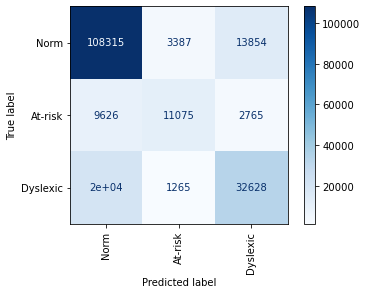

In [46]:


disp = sklearn.metrics.plot_confusion_matrix(
    mdl, x_train, y_train, 
    display_labels=class_names, 
    cmap=plt.cm.Blues, 
    xticks_rotation='vertical'
)




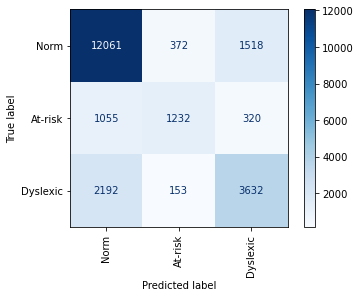

In [49]:


disp = sklearn.metrics.plot_confusion_matrix(
    mdl, x_test, y_test, 
    display_labels=class_names, 
    cmap=plt.cm.Blues, 
    xticks_rotation='vertical'
)




In [50]:

sklearn.metrics.roc_auc_score(y_test, 
                              mdl.predict_proba(x_test),
                              multi_class='ovr',
                              average="weighted"
                             )




0.8684219618516742

In [51]:

sklearn.metrics.roc_auc_score(y_train, 
                              mdl.predict_proba(x_train),
                              multi_class='ovr',
                              average="weighted"
                             )



0.8675002691339172

## Conclusion

I see no over/under fitting

## Dumping the model






In [52]:

filename = "mlp_fix_demo_no_iq_01.pickle"


In [ ]:


# pickle.dump(mdl, open(filename, "wb"))



In [53]:

print("the fitted model saved!")


the fitted model saved!



## Loading the retrained model



In [54]:


loaded_model = pickle.load(open(filename, "rb"))



## Testing the loaded model



In [55]:


y_prob_ = loaded_model.predict_proba(x_test)
y_pred_ = loaded_model.predict(x_test)



In [56]:


sklearn.metrics.roc_auc_score(y_test, 
                              loaded_model.predict_proba(x_test),
                              multi_class="ovr",
                              average="weighted"
                             )



0.8684219618516742

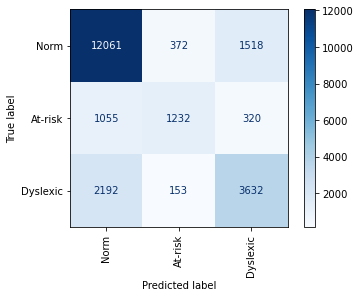

In [57]:


disp = sklearn.metrics.plot_confusion_matrix(
    loaded_model, x_test, y_test, 
    display_labels=class_names, 
    cmap=plt.cm.Blues, 
    xticks_rotation='vertical'
)




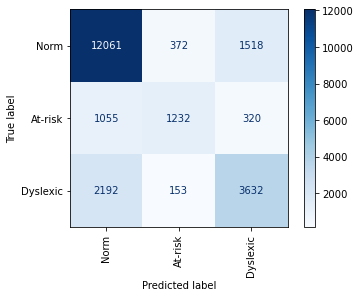

In [58]:


disp = sklearn.metrics.plot_confusion_matrix(
    mdl, x_test, y_test, 
    display_labels=class_names, 
    cmap=plt.cm.Blues, 
    xticks_rotation='vertical'
)







## Conclusion

Everything seems okay.
